In [5]:
# Import necessary libraries
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [6]:
# Initialize a BigQuery client
client = bigquery.Client(project='container-testing-381309')

# Function to execute BigQuery and return results as a DataFrame
def run_bigquery(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

# Read user_info table
user_info_query = """
SELECT *
FROM `container-testing-381309.telegram.user_info`
"""
user_info_df = run_bigquery(user_info_query)

# Read chat_history table
chat_history_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_history`
"""
chat_history_df = run_bigquery(chat_history_query)

# Read chat_info table
chat_info_query = """
SELECT *
FROM `container-testing-381309.telegram.chat_info`
"""


/opt/homebrew/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


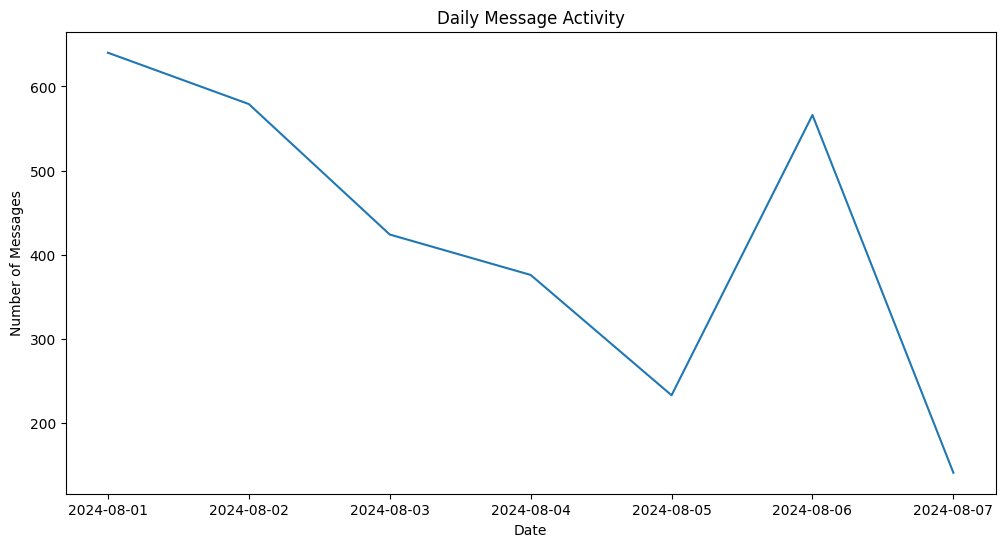

In [7]:
chat_history_df['date'] = pd.to_datetime(chat_history_df['date'])
daily_activity = chat_history_df.groupby(chat_history_df['date'].dt.date).size()

plt.figure(figsize=(12, 6))
daily_activity.plot()
plt.title('Daily Message Activity')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.show()

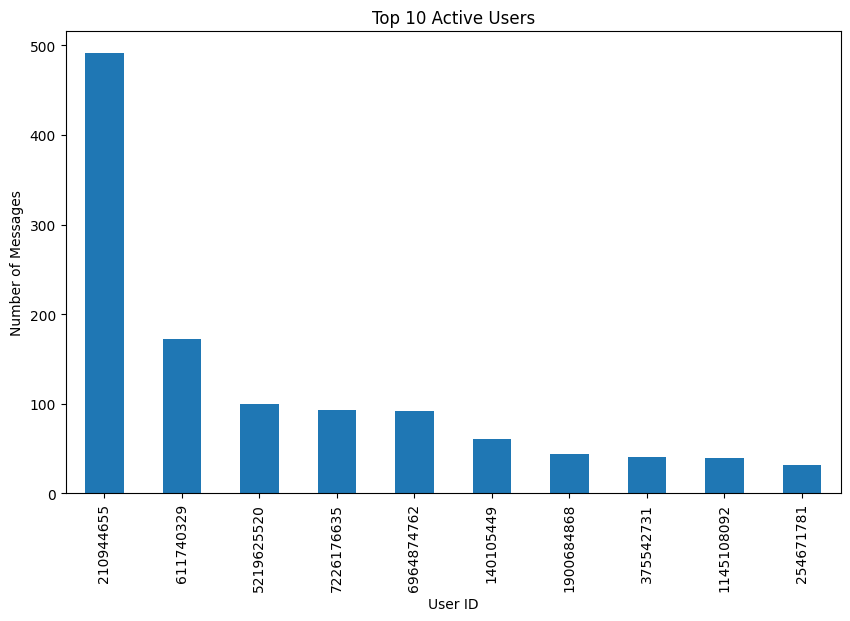

In [8]:
top_users = chat_history_df['from_user'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_users.plot(kind='bar')
plt.title('Top 10 Active Users')
plt.xlabel('User ID')
plt.ylabel('Number of Messages')
plt.show()

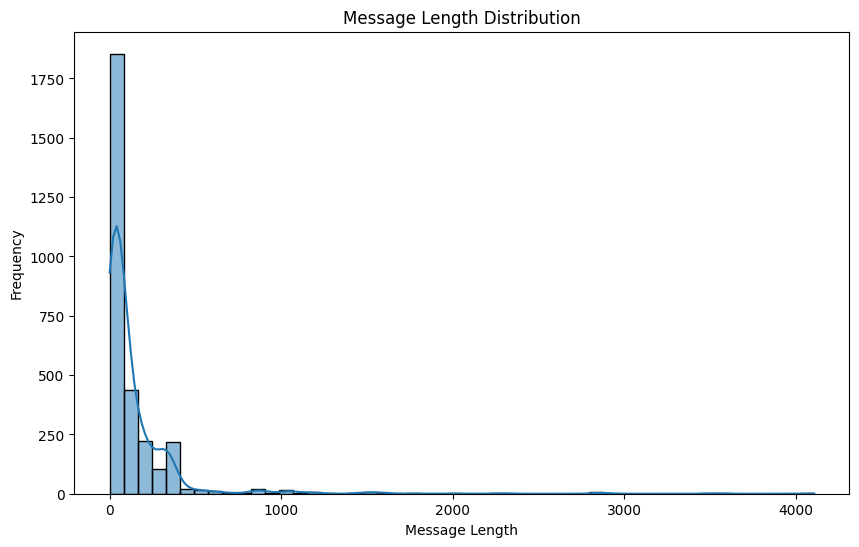

In [9]:
chat_history_df['message_length'] = chat_history_df['text'].astype(str).str.len()
plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['message_length'], bins=50, kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

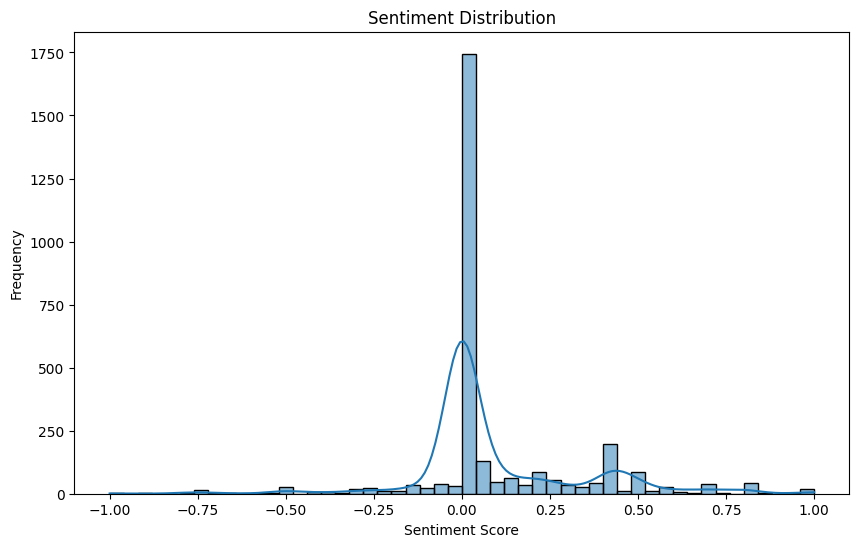

In [10]:
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

chat_history_df['sentiment'] = chat_history_df['text'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.histplot(chat_history_df['sentiment'], bins=50, kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


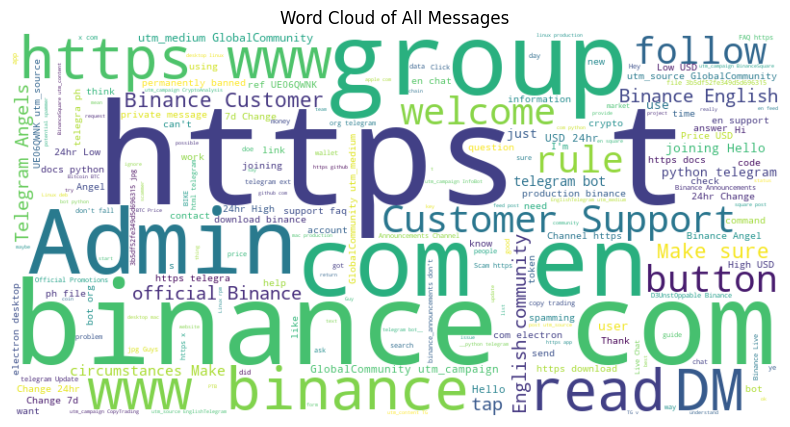

In [23]:
all_text = ' '.join(chat_history_df['text'].astype(str))
stopwords = set(CountVectorizer(stop_words='english').get_stop_words())
stopwords = stopwords.union(set(['http', 'https', 'www', 'com', 'org', 'net', 'telegram', 't', 'com']))
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stopwords).generate(all_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')
plt.show()

In [12]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(chat_history_df['text'].astype(str))

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("\nTop words for each topic:")
print_top_words(lda, vectorizer.get_feature_names_out(), 10)


Top words for each topic:
Topic 1: binance, com, https, en, globalcommunity, www, support, chat, utm_medium, utm_source
Topic 2: binance, com, https, download, bot, linux, telegram, python, app, desktop
Topic 3: https, don, just, file, telegra, ph, channel, bot, guys, like
Topic 4: telegram, binance, hello, group, make, support, sure, dm, welcome, read
Topic 5: https, usd, 24hr, change, price, 7d, high, low, com, status


In [13]:
chat_history_df['has_media'] = chat_history_df['media'].notna()
chat_history_df['has_reaction'] = chat_history_df['reactions'].notna()

user_engagement = chat_history_df.groupby('from_user').agg({
    'id': 'count',
    'has_media': 'sum',
    'has_reaction': 'sum',
    'views': 'mean',
    'forwards': 'sum'
}).reset_index()

user_engagement.columns = ['user_id', 'total_messages', 'media_messages', 'messages_with_reactions', 'avg_views', 'total_forwards']

print("\nUser Engagement Summary:")
print(user_engagement.describe())


User Engagement Summary:
                 user_id  total_messages  media_messages  \
count              655.0           655.0      655.000000   
mean   3600684924.462595        4.517557        0.410687   
std    2733793091.739506        21.69963        4.043064   
min           13333606.0             1.0        0.000000   
25%          940982704.0             1.0        0.000000   
50%         2099500384.0             1.0        0.000000   
75%         6344798788.5             3.0        0.000000   
max         7499392850.0           491.0       91.000000   

       messages_with_reactions   avg_views  total_forwards  
count               655.000000       655.0           655.0  
mean                  4.517557   24.700763        0.453435  
std                  21.699630  610.304265       10.959637  
min                   1.000000         0.0             0.0  
25%                   1.000000         0.0             0.0  
50%                   1.000000         0.0             0.0  
75%   

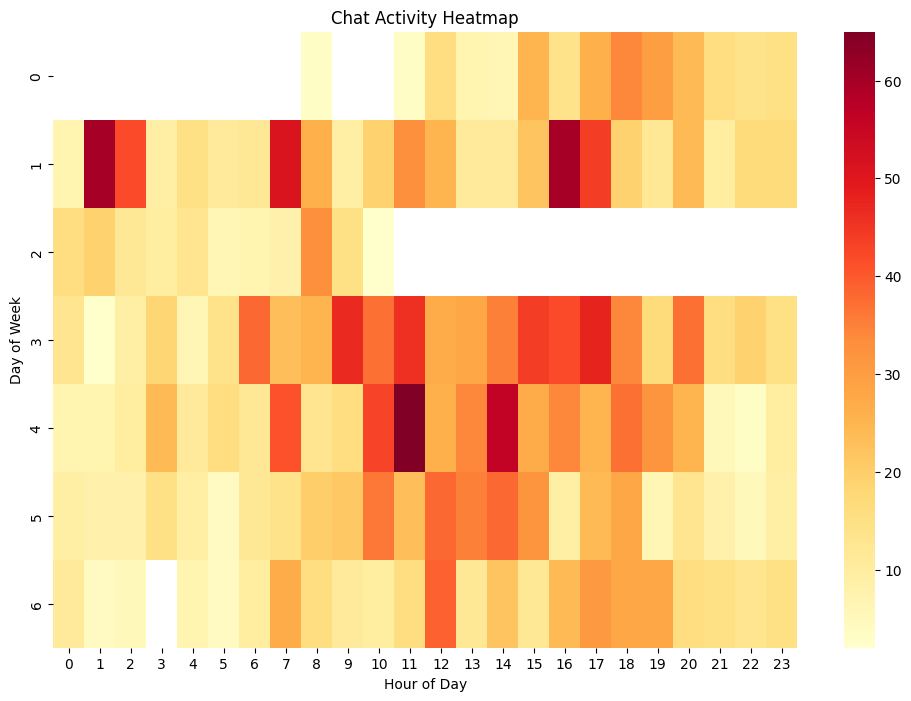

In [14]:
chat_history_df['hour'] = chat_history_df['date'].dt.hour
chat_history_df['day_of_week'] = chat_history_df['date'].dt.dayofweek

activity_heatmap = chat_history_df.groupby(['day_of_week', 'hour']).size().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap='YlOrRd')
plt.title('Chat Activity Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

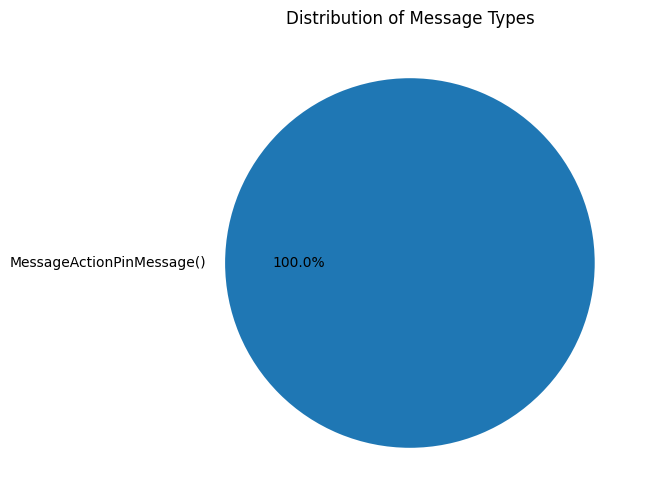

In [15]:
message_types = chat_history_df['action'].value_counts()

plt.figure(figsize=(10, 6))
message_types.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Message Types')
plt.ylabel('')
plt.show()

/opt/homebrew/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


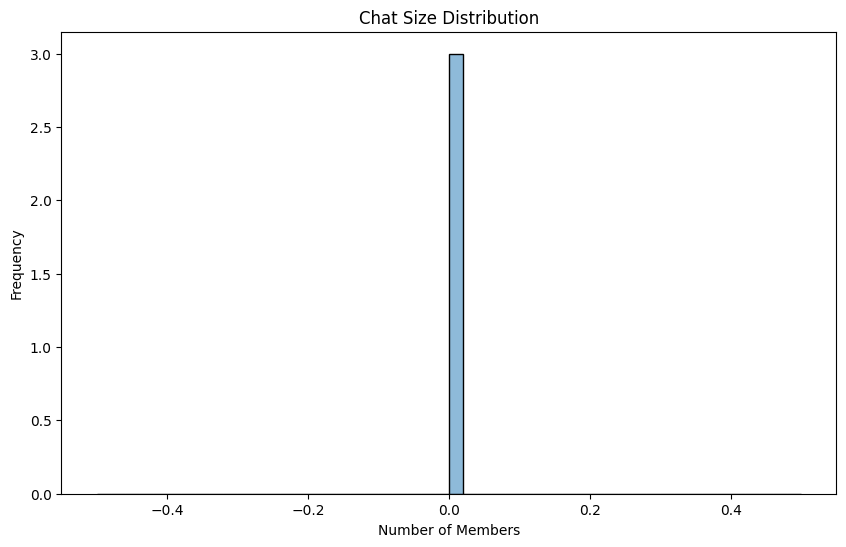

In [22]:
chat_info_df = run_bigquery(chat_info_query)

plt.figure(figsize=(10, 6))
sns.histplot(chat_info_df['members_count'], bins=50, kde=True)
plt.title('Chat Size Distribution')
plt.xlabel('Number of Members')
plt.ylabel('Frequency')
plt.show()

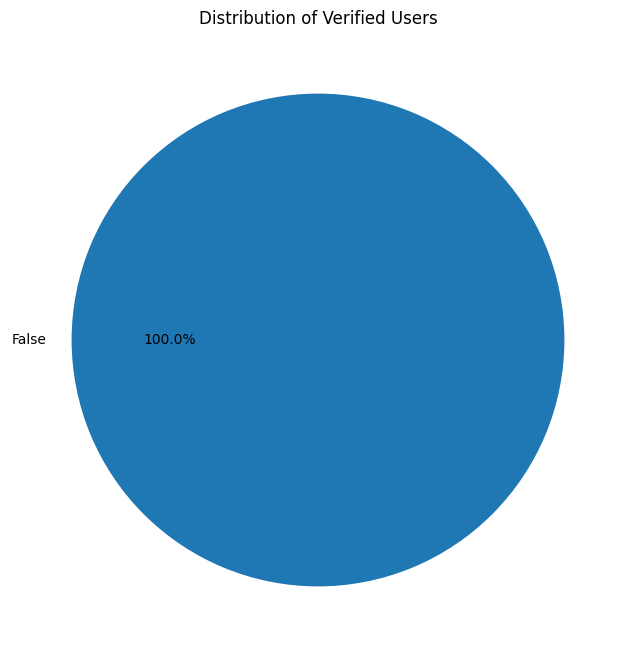

In [17]:
verified_users = user_info_df['verified'].value_counts()
plt.figure(figsize=(8, 8))
verified_users.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Verified Users')
plt.ylabel('')
plt.show()


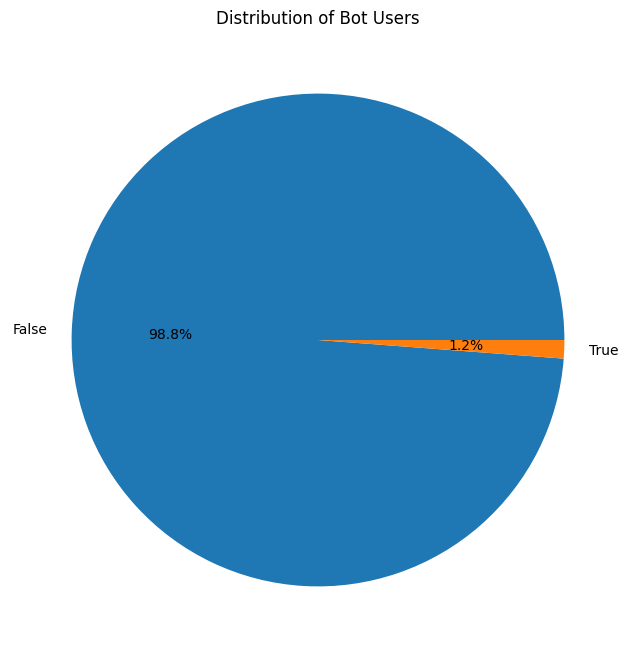

In [18]:
bot_users = user_info_df['bot'].value_counts()
plt.figure(figsize=(8, 8))
bot_users.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Bot Users')
plt.ylabel('')
plt.show()

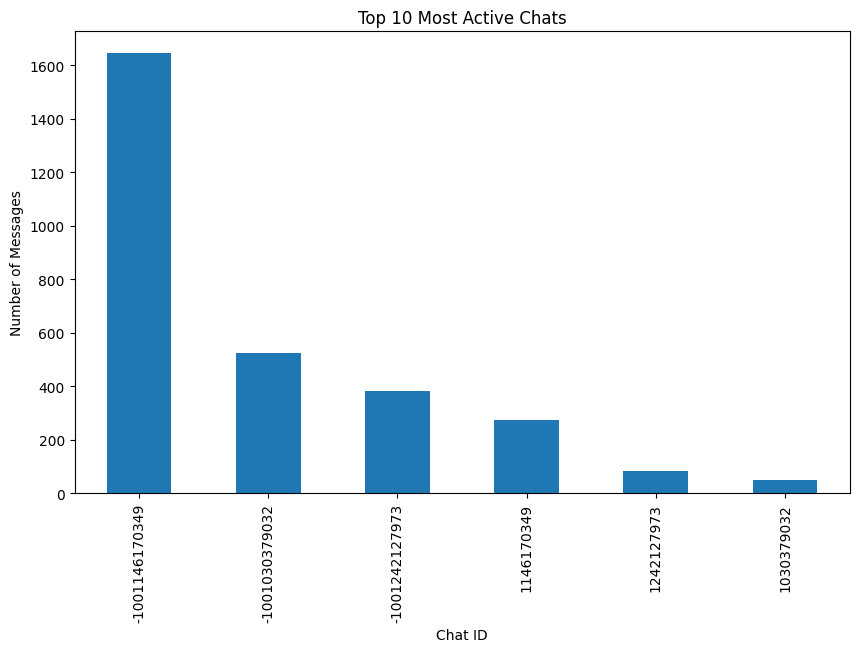

In [19]:
top_chats = chat_history_df['chat_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_chats.plot(kind='bar')
plt.title('Top 10 Most Active Chats')
plt.xlabel('Chat ID')
plt.ylabel('Number of Messages')
plt.show()


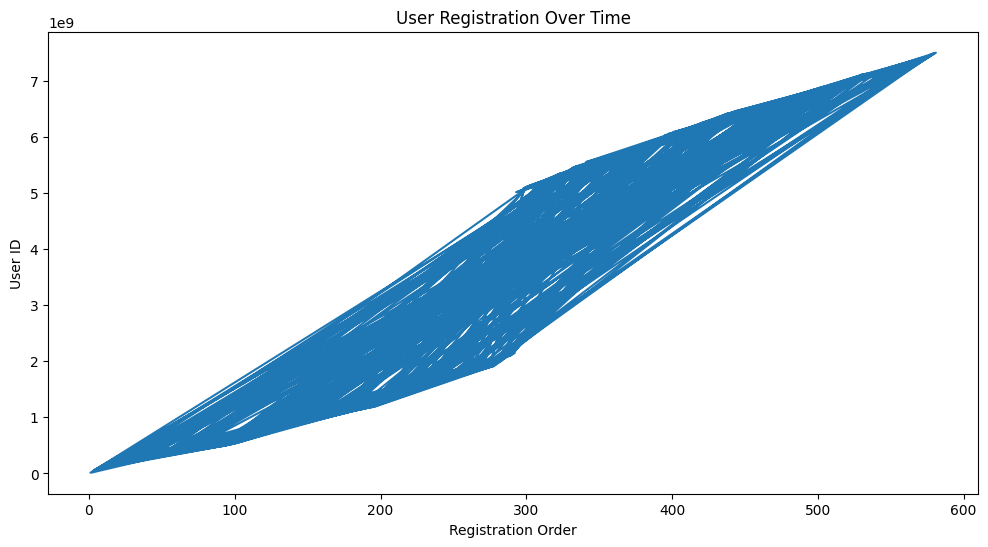

In [20]:
user_info_df['registration_order'] = user_info_df['id'].rank(method='first')
plt.figure(figsize=(12, 6))
plt.plot(user_info_df['registration_order'], user_info_df['id'])
plt.title('User Registration Over Time')
plt.xlabel('Registration Order')
plt.ylabel('User ID')
plt.show()
